In [18]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import ElectraTokenizer, ElectraForSequenceClassification, ElectraModel, pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
#import torch_xla.core.xla_model as xm
from torch.optim import AdamW
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import random
!pip install openai
from openai import OpenAI
from kaggle_secrets import UserSecretsClient
from IPython.display import display
import matplotlib.pyplot as plt
!pip install tiktoken
import matplotlib.font_manager as fm

In [2]:
import pandas as pd

ssg_ramen = pd.read_csv('/kaggle/input/reviews-collective/ssg-negative-ramen_1.csv')
ssg_frozen = pd.read_csv('/kaggle/input/reviews-collective/ssg-negative-frozen.csv')

In [16]:
danawa_ramen = pd.read_csv('/kaggle/input/reviews-collective/danawa-negative-ramen.csv')
danawa_ramen 

,review,sentiment,aspect,mall
0,만족합니다 만족합니다,1,기타,옥션
1,"배송도 진짜 거지같고(10월 5일 주문. 10월12일에 받음), 주문시 유통기한 문의했더니 품절이라 모르겠다고 하더니만, 40개입 한박스를 유통기한 3개월 남은거 보냄. 거기에 박스 한쪽은 뚜껑이 열려있음..아..다시는 여기서 주문안합니다.",0,"배송, 유통기한, 서비스",G마켓
2,"진라면을 수도 없이 시켜봤지만 이런배송은 첨 받아봅니다어디 쓰레기장 굴러다니던거 보내셨는지 파손 개봉된 상품 문의 남겨도 답변도 시원찮게 해주고 ssg이름 걸고 지마켓에서 팔았으면 이름값에 맞게 대응하셔야 되는데 거의 일주일째 정확한 답변도 주지 않고 담담자 부재만 얘기 하고 계시네요ssg,지마켓,오뚜기에 똥칠하지 마세요!",0,"배송, 서비스",G마켓
3,배송은 빠르나 유통기한 너무 짧네요.2달 남았다고 표시 해주셨으면 좋았을텐데..,0,유통기한,옥션
4,박스 단위로 산다면 유통 기한이 짧네요,0,유통기한,옥션
...,...,...,...,...
289,잘받았음,1,기타,옥션
290,배송 느림,0,배송,옥션
291,좋아요,1,기타,옥션
292,좋아요님님들도구매,1,기타,옥션


In [3]:
ssg_frozen

,review,sentiment,aspect,category
0,배송도 빠르고 좋아요,1,배송,냉장냉동
1,백종원 유?보고 쏘세지 마탕 해 먹으려고 샀어요.,1,기타,냉장냉동
2,쓱배송 좋아요 저렴하고 편하게 잘샀어요,1,"배송, 가격",냉장냉동
3,저렴하게 잘 샀네요. 맛있어요.,1,가격,냉장냉동
4,가격이 올랐지만 맛있어요,2,가격,냉장냉동
...,...,...,...,...
856,"후기가 워낙 많아 샀는데, 달고 짜고. 오죽하면 물에 헹궈서 조리했을까요? 애들은 ...",0,기타,냉장냉동
857,별로임 배송 올때마다 하나씩.품절이라 더 맘에 안듬,0,배송,냉장냉동
858,솔직히 너무맛없어요 다들 뭔 리뷰를 이리도 구구절절 써놓는겁니까 리뷰보다 맛있는줄 ...,0,기타,냉장냉동
859,한번먹기엔 좋은데 재구매는 안할듯,0,기타,냉장냉동


In [19]:
def process_danawa(danawa_frozen):

    danawa_frozen = danawa_frozen[danawa_frozen['sentiment'] == 0].copy()
    danawa_frozen = danawa_frozen[danawa_frozen['mall'].isin(['G마켓', '옥션']) ]
    danawa_frozen.dropna(inplace = True)
    danawa_frozen.drop_duplicates(subset= ['review'], inplace= True)
    gmarket_frozen = danawa_frozen[danawa_frozen['mall'] == 'G마켓']
    auction_frozen = danawa_frozen[danawa_frozen['mall'] == '옥션']
    auction_frozen.reset_index(inplace =True, drop = True)
    gmarket_frozen.reset_index(inplace =True, drop = True)
    
    return auction_frozen, gmarket_frozen

danawa_ramen = pd.read_csv('/kaggle/input/reviews-collective/danawa-negative-ramen.csv')
danawa_frozen = pd.read_csv('/kaggle/input/reviews-collective/danawa-negative-frozen.csv')

auction_ramen, gmarket_ramen = process_danawa(danawa_ramen)
auction_frozen, gmarket_frozen = process_danawa(danawa_frozen)


def process_ssg(df):
    df = df[df['sentiment'] == 0 ].copy()
    df.dropna(inplace = True)
    df.drop_duplicates(subset = ['review'], inplace = True)
    df.reset_index(inplace = True, drop = True)
    return df

ssg_ramen = pd.read_csv('/kaggle/input/reviews-collective/ssg-negative-ramen_1.csv')
ssg_frozen = pd.read_csv('/kaggle/input/reviews-collective/ssg-negative-frozen.csv')

auction_ramen.loc[auction_ramen['aspect'] == '가격이' , 'aspect'] = '가격'

ssg_ramen = process_ssg(ssg_ramen)
ssg_frozen = process_ssg(ssg_frozen)

def mlb_encode(df):
    
    mlb = MultiLabelBinarizer()
    df['aspect'] = df['aspect'].apply(lambda x: x.split(', '))
    encoded = mlb.fit_transform(df['aspect'])
    encoded_df = pd.DataFrame(encoded, columns = mlb.classes_)
    df = pd.concat( (df, encoded_df), axis = 1 )
    df.drop(columns = ['sentiment'], inplace = True)
    return df 


ssg_ramen = mlb_encode(ssg_ramen)
ssg_frozen = mlb_encode(ssg_frozen)
auction_ramen = mlb_encode(auction_ramen)
auction_frozen = mlb_encode(auction_frozen)
gmarket_ramen = mlb_encode(gmarket_ramen)
gmarket_frozen = mlb_encode(gmarket_frozen)
auction_ramen.drop(columns = ['mall'], inplace = True)
gmarket_ramen.drop(columns = ['mall'], inplace = True)
auction_frozen.drop(columns = ['mall'], inplace = True)
gmarket_frozen.drop(columns = ['mall'], inplace = True)
ssg_ramen.drop(columns = ['category'], inplace = True)
ssg_frozen.drop(columns = ['category'], inplace = True)

def kor_to_eng(df):
    df.rename(columns = {'가격' : 'price', '기타' : 'others', '배송' : 'delivery', '서비스' : 'service', '오류' : 'error'\
              ,'유통기한' : 'expiration', '품질' : 'quality'}, inplace = True)

kor_to_eng(ssg_ramen)
kor_to_eng(ssg_frozen)
kor_to_eng(auction_ramen)
kor_to_eng(auction_frozen)
kor_to_eng(gmarket_ramen)
kor_to_eng(gmarket_frozen)
auction_frozen.drop(columns = '배성', inplace = True)

In [20]:
ssg_ramen[ssg_ramen['service'] == 1].tail(30)


,review,aspect,price,others,delivery,service,error,expiration,quality
0,이마트가 쿠팡에 한참 밀리는 이유 쓱배송 시켜보면 단박에 이해가능하다. 시대에 떨어지는 상담과 처리방식.,"[배송, 서비스]",0,0,1,1,0,0,0
8,이마트 리뷰 보상이 이런식이니까 망해가는거여,[서비스],0,0,0,1,0,0,0
31,쓱머니 꼴랑 50원 주면서 엄청 귀찮게 만들었네요.!!,[서비스],0,0,0,1,0,0,0
34,리뷰 제한을 이따위로 걸어놓고 뭔 리뷰를 쓰라는거여,[서비스],0,0,0,1,0,0,0
39,한달한번구매하고 다른사이트에서 네번구매하네요 리뷰작성 아주 안좋네요,[서비스],0,0,0,1,0,0,0
45,리뷰 20개 작성하면 포인트 주는거 이제 40개로 늘어났네요? 갈수록 맘에 안드는 신세계..,[서비스],0,0,0,1,0,0,0
48,"월 40건 제한, 동일 옵션 30일 내 미적립 경고문이 사라졌네 굳굳~~~",[서비스],0,0,0,1,0,0,0
52,늘 쟁여놓고 먹는데 이번에 불량제품이 배송됐네요 ㅜㅜ 교환신청은 대체 어떻게 하는건지 안내도 없고..,"[서비스, 품질]",0,0,0,1,0,0,1
54,아주 시스템이 구려졌네 이걸 개편했다고 50원 주기도 아까우면 주지말던지 시스템 축소라고 하지 화려하게 안내하더니 거래끝 귀찮네요,[서비스],0,0,0,1,0,0,0
60,"주문한거 빠뜨리고 환불요청해도 안해주고 재차 요청해야해줌 그것도 적립금으로 해줌 의정부이마트 주문한 물건을 자주 빼먹음 확인 안해서 그냥 넘어간적도 많을거임 저번주엔 단무지 다터져서왔는데 봉지를 3개나 감싸서 온거보니 터진거 알고 그냥 배송한듯 안먹고 다버림, 의정부이마트 문제가 많아요 거의 십년동안 5지역에서 주문 했지만 불만족은 처음 쓰는중","[서비스, 오류]",0,0,0,1,1,0,0


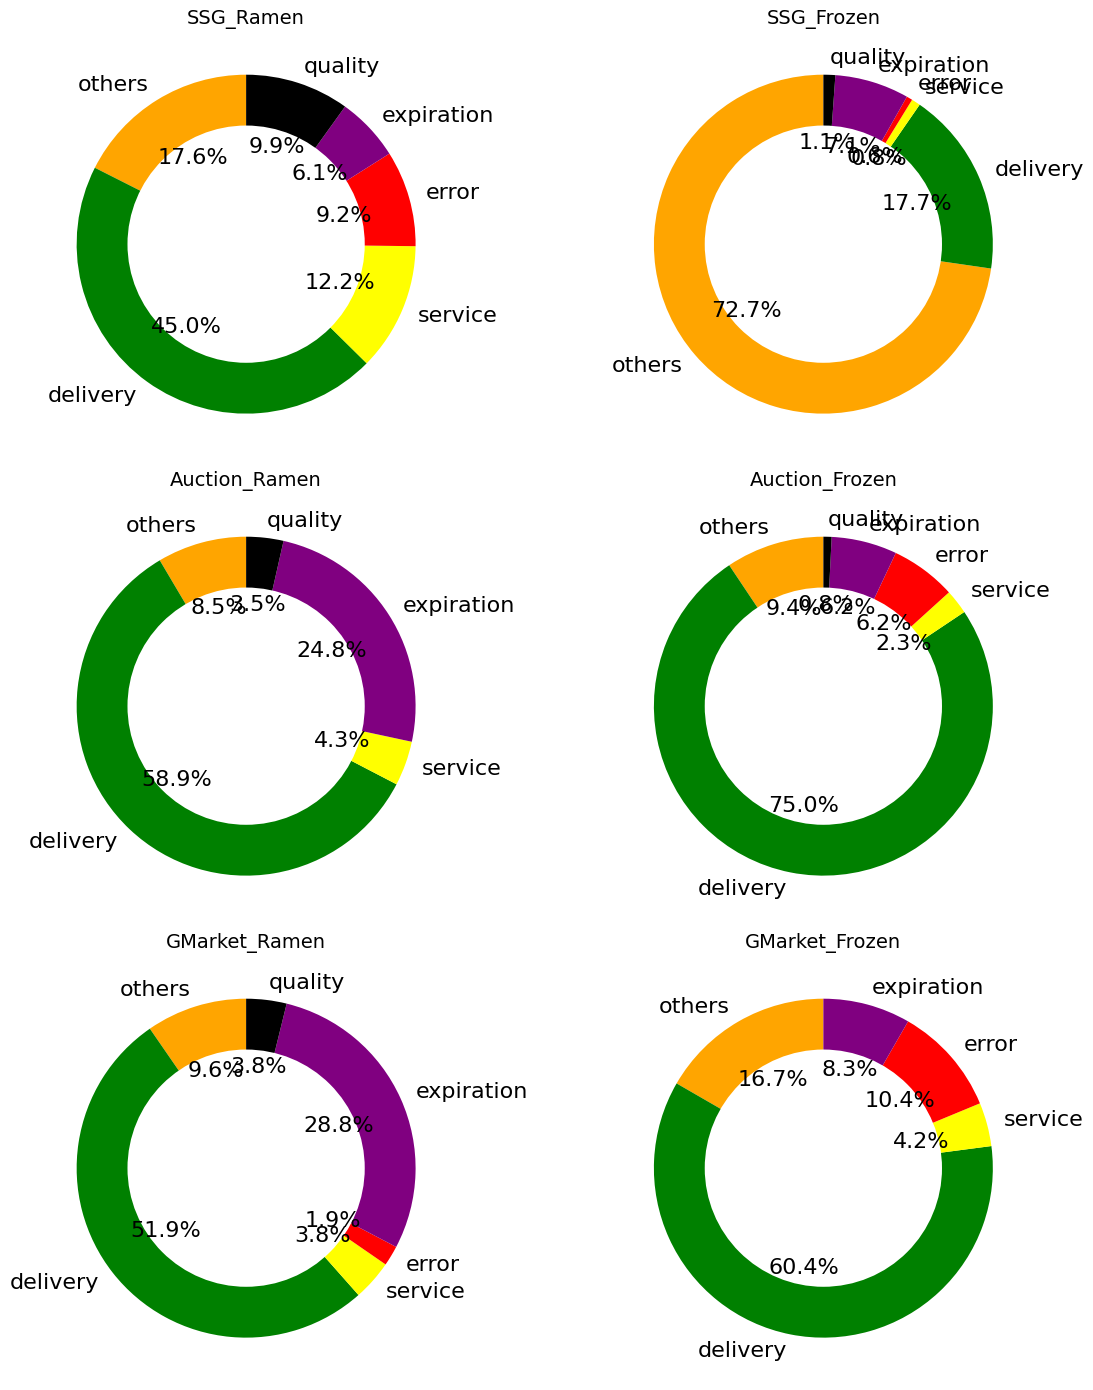

In [21]:
def make_piechart(df, ax):
    col_sum = df.iloc[:, 3:].sum()

    section_colors = {
        'price' : 'blue',
        'others' : 'orange',
        'delivery' : 'green',
        'error' : 'red',
        'expiration' : 'purple',
        'quality' : 'black',
        'service' : 'yellow'
    }

    colors = [section_colors.get(section , 'gray')  for section in col_sum.index]
    wedges, texts, autotexts = ax.pie(
        col_sum, labels = col_sum.index, autopct = '%1.1f%%', startangle = 90, colors = colors, textprops={'fontsize': 16}
    )

    center_circle = plt.Circle( (0,0), 0.7, fc ='white' )
    ax.add_artist(center_circle)


def show_piechart(df1, df2, df3, df4, df5, df6):

    fig, axes = plt.subplots(3, 2, figsize = (12, 14))
    axes =axes.flatten()

    
    make_piechart(df1, axes[0])
    make_piechart(df2, axes[1])
    make_piechart(df3, axes[2])
    make_piechart(df4, axes[3])
    make_piechart(df5, axes[4])
    make_piechart(df6, axes[5])

    axes[0].set_title('SSG_Ramen', fontsize = 14)
    axes[1].set_title('SSG_Frozen', fontsize = 14)
    axes[2].set_title('Auction_Ramen', fontsize = 14)
    axes[3].set_title('Auction_Frozen', fontsize = 14)
    axes[4].set_title('GMarket_Ramen', fontsize = 14)
    axes[5].set_title('GMarket_Frozen', fontsize = 14)
    
    
    plt.tight_layout()
    plt.show()


show_piechart(ssg_ramen, ssg_frozen, auction_ramen, auction_frozen, gmarket_ramen, gmarket_frozen)



g마켓, 옥션의 경우 라면 품목에서 유통기한에 대한 불만이 쓱닷컴에 비해 4~5배 가량 많은 편. 쓱닷컴의 냉장/냉동식품의 경우 맛에 대한 불만이 많은 편 
지마켓, 옥션 냉장/냉동식품의 경우 배달에 대한 불만이 60~70%가량으로 가장 두드러짐

In [8]:
pd.set_option('display.max_colwidth', None)

In [13]:
auction_frozen = pd.read_csv('/kaggle/input/filterted-reviews/auction_frozen_filtered.csv', index_col = 0)
auction_frozen[auction_frozen['category'] == 'package issue']

,review,category
5,상자가 찢어서 왔어요. 요즘 나오는 사골곰탕이 아닌가보네요. 유통기한도 짧아요18개 부지런히 먹어야 하겠어요.,package issue
9,18개 1박스라 18개 주문했는데 낱개로 박스애 담아 보냐니 박스가 걸래가 되도룍 찢어져서 백배아저씨가 태이프로 덕지 덕지포장이 엉망입니다,package issue
14,즐겨 주문하는 제품인데 박스가 젖어 있어 혹시나 했는데 꺼내서 확인하니 1개가 터져있네요혹시나 박스 외관을 확인한 결과 박스에 이상이 없고 제품에만 상처가 있어 포장 시 터진것을 넣은것 같네요,package issue
17,"택배사에서 그런것 같은데, 포장 상태가 도데체 이해할수 없네요, 박스는 왜이래 찢어 졌으며 내용물이 터졌는 지 박스는 졌어 있고, 무슨 쓰레기도 아니고ㅠㅠ 반품 신청 합니다.",package issue
23,왜 구지 박스의 물건을 풀어서 낱개로 보내시지요?18개면 1박스 통째 보내면 될걸.,package issue
24,미리 터질꺼알고 밑에 비닐깔고 보내셧나요??...사골 자주시켜먹는데...이런택배 첨받아보네요...당장 반품처리해주세요,package issue
32,사골육수가 터져서 박스가 엉망입니다.빠른시간내에 연락과 교환 부탁드립니다.,package issue
34,배송된 물품이 하나가 파손되어 국물이 온집에 질질 흘렸습니다청소힌다고 신경질남,package issue
36,상품 선전 포장과 배송된 상품의 사진이 틀려요.,package issue
42,박스가 너덜너덜하게 왓네요1개가 터져서 끈적끈적해요,package issue


In [15]:
auction_ramen = pd.read_csv('/kaggle/input/filterted-reviews/auction_ramen_filtered.csv', index_col = 0)
auction_ramen[auction_ramen['category'] == 'expiration']

,review,category


In [22]:
ssg_frozen = pd.read_csv('/kaggle/input/filterted-reviews/ssg_frozen_filtered.csv', index_col = 0)
ssg_ramen = pd.read_csv('/kaggle/input/filterted-reviews/ssg_ramen_filtered.csv', index_col = 0)
gmarket_ramen = pd.read_csv('/kaggle/input/filterted-reviews/gmarket_ramen_filtered.csv', index_col = 0)
gmarket_frozen = pd.read_csv('/kaggle/input/filterted-reviews/gmarket_frozen_filtered.csv', index_col = 0)
auction_ramen = pd.read_csv('/kaggle/input/filterted-reviews/auction_ramen_filtered.csv', index_col = 0)
auction_frozen = pd.read_csv('/kaggle/input/filterted-reviews/auction_frozen_filtered.csv', index_col = 0)
ssg_frozen = ssg_frozen.drop(ssg_frozen.columns[0], axis = 1)


ssg_ramen.reset_index(inplace = True, drop = True)
gmarket_ramen.reset_index(inplace = True, drop = True)
gmarket_frozen.reset_index(inplace = True, drop = True)
auction_frozen.reset_index(inplace = True, drop = True)
auction_ramen.reset_index(inplace = True, drop = True)
ssg_frozen.reset_index(inplace = True, drop = True)

def mlb_encode(ssg_frozen):
    mlb = MultiLabelBinarizer()
    ssg_frozen['category'] = ssg_frozen['category'].apply(lambda x: x.strip())
    ssg_frozen['category'] = ssg_frozen['category'].apply(lambda x: x.split(', '))
    ssg_frozen_encoded  = mlb.fit_transform(ssg_frozen['category'])
    encoded_df = pd.DataFrame(ssg_frozen_encoded, columns= mlb.classes_)
    ssg_frozen =pd.concat( (ssg_frozen, encoded_df)  ,axis = 1)
    return ssg_frozen


ssg_frozen = mlb_encode(ssg_frozen)
gmarket_ramen = mlb_encode(gmarket_ramen)
gmarket_frozen = mlb_encode(gmarket_frozen)
auction_frozen = mlb_encode(auction_frozen)
auction_ramen = mlb_encode(auction_ramen)
ssg_ramen = mlb_encode(ssg_ramen)

pd.set_option('display.max_colwidth', None)

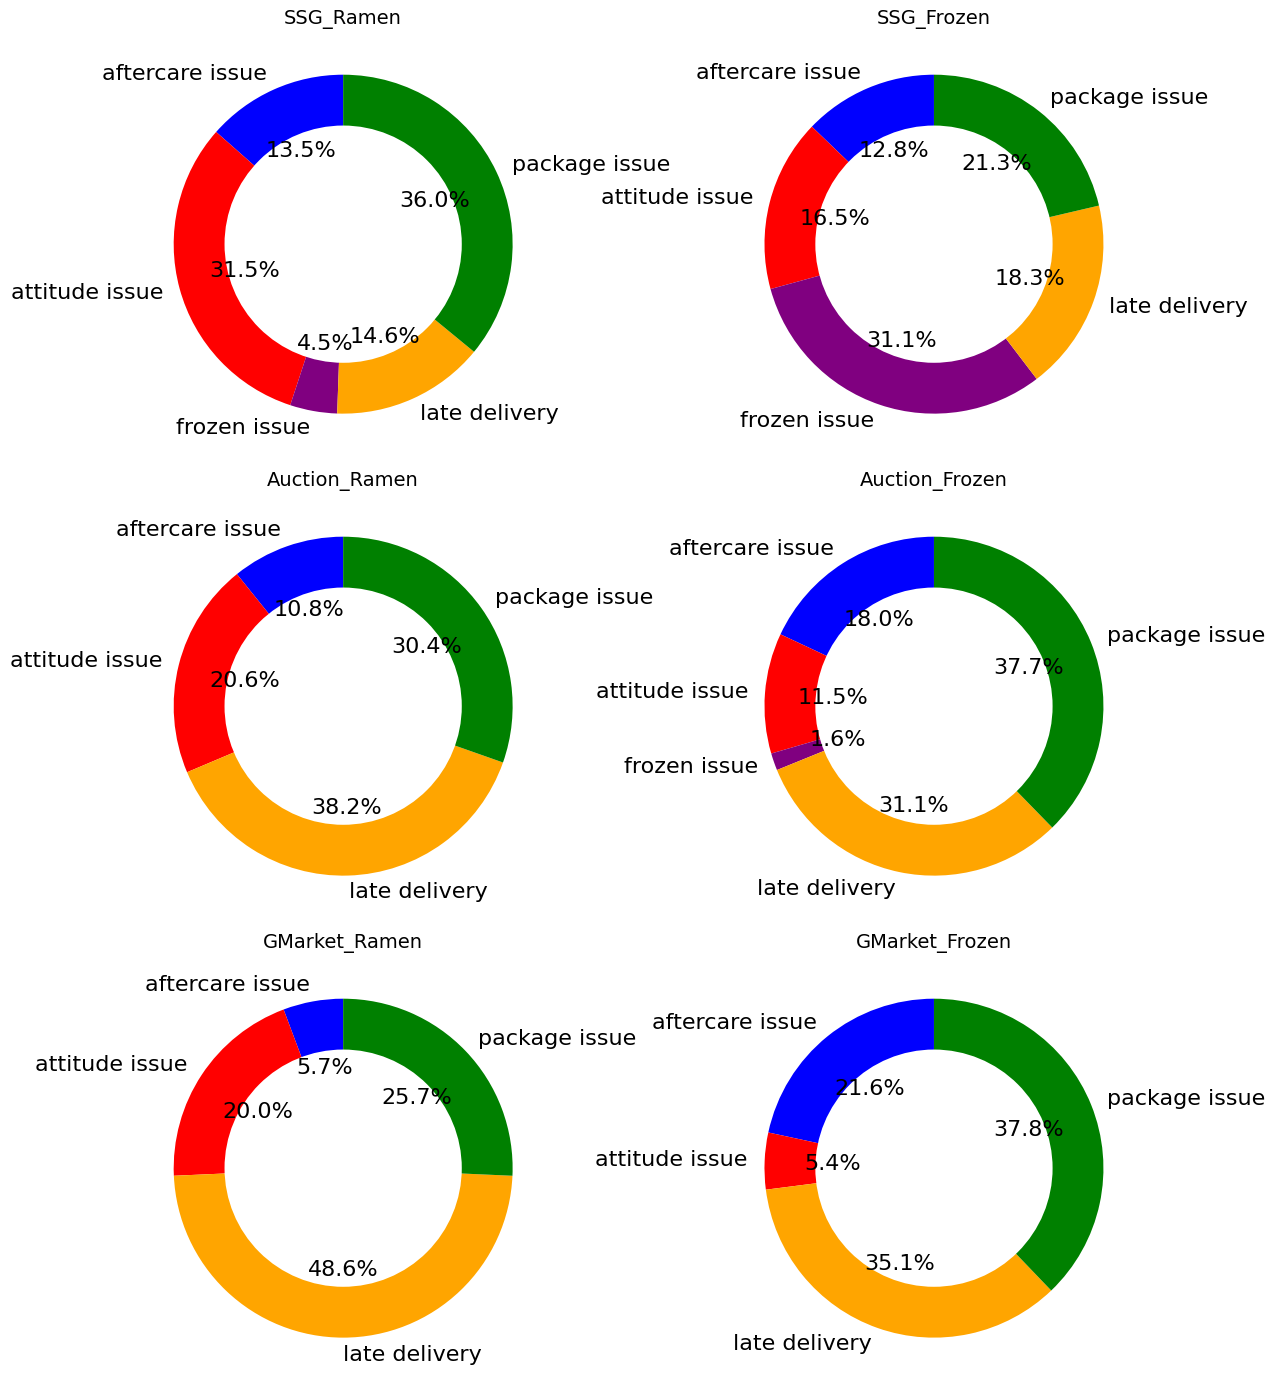

In [28]:
def cal_prop(df, ax):
    df_sum = df.iloc[:, 2:].sum()
    
    section_colors_mapping = {
    'aftercare issue': 'blue',
    'late delivery': 'orange',
    'package issue': 'green',
    'attitude issue': 'red',
    'frozen issue': 'purple'
    }
    
    colors = [section_colors_mapping.get(section, 'gray') for section in df_sum.index]
    wedges, texts, autotexts = ax.pie(
        df_sum, labels = df_sum.index, autopct = '%1.1f%%', startangle = 90, colors = colors,  textprops={'fontsize': 16}
    )
    
    center_circle = plt.Circle( (0,0), 0.7, fc = 'white')
    ax.add_artist(center_circle)

def show_piechart(df1, df2, df3, df4, df5, df6):



    fig, axes = plt.subplots(3, 2, figsize = (12, 14))
    axes = axes.flatten()
    
    cal_prop(df1, axes[0])
    cal_prop(df2, axes[1])
    cal_prop(df3, axes[2])
    cal_prop(df4, axes[3])
    cal_prop(df5, axes[4])
    cal_prop(df6, axes[5])

    axes[0].set_title('SSG_Ramen', fontsize = 14)
    axes[1].set_title('SSG_Frozen', fontsize = 14)
    axes[2].set_title('Auction_Ramen', fontsize = 14)
    axes[3].set_title('Auction_Frozen', fontsize = 14)
    axes[4].set_title('GMarket_Ramen', fontsize = 14)
    axes[5].set_title('GMarket_Frozen', fontsize = 14)
    
    plt.tight_layout()
    plt.show()


show_piechart(ssg_ramen, ssg_frozen, auction_ramen, auction_frozen, gmarket_ramen, gmarket_frozen)



지마켓, 옥션은 늦은 배송의 문제가 대두됨 <br>
쓱닷컴은 냉동포장 문제가 상대적으로 큼 (아이스팩을 안넣거나 다 녹아서 오거나 빨리 배송되어서 녹음) <br>
라면 부서지는 문제 <br>
포장문제?

In [24]:


ssg_ramen_package = auction_ramen[auction_ramen['aftercare issue'] == 1]

ssg_ramen_package[['review']]

,review
0,살다. 살다 택배 이렇게 드럽게 오는건 첨이네요어제 오늘 비가 온것도 아니고. 어떻게 이따구로말 한마디 없이 놓고 갑니까. 안에 라면 비닐까지젖어 있던데. 어찌하면 이리 되는지이정도면 알아서 파손 처리 하고 반품해가야 하는게맞지. 않을까요지금까지 반품해본적이 없고. 귀찮아 서. 그냥 두는데정말 어이상실 이네요. 먹기 기분이 참 뭐하네요
25,배송문의에 답도 없고 배송도 느립니다cs가 엉망이에요
29,"배송 느리고, 배송되지. 않았음에도 배송완료처리하고. . 실망입니다."
32,배송이 너무 너무 늦네요~~~4박5일이나 되고 그 동안 팬매자는 연락도 없구!!! 좀 짜증나요~~~
37,2022.9.15 주문하였는데 9.21 도착하였습니다.대부분 배송기간이 3일이내 도착하지만 여기 업체는 지연된다는문자 하나 보내지 않고 있어 매우 불편합니다.
42,다음날 배송된다던 스마일배송이 2박3일 꽉 채왔습니다.배송지연보상없는 스마일배송 때려치워라.
47,월요일에 주문해서 목요일에 받음 새벽배송이란 말이 무색하군요 *팡에서는 하루만 늦어도 미안하다고 포인트 팍팍 주는데 옥션은 전화하고 문자만 엄청하는군요 미안하다고...친절한건 좋은데 말로만 귀챦게 하지말고진심을 보이길
49,스마일배송이 왜 이런가요? 물건은 옆동에 배달해놓고 배달완료 문자도 없고......옆동에서 물건 가지고 가라해서 가지고왔네요배송에 신경좀 써주세요
50,구매자가 신뢰할수있도록해주시기 바랍니다.물품이배송되여 어쩔수없이 반품철회했습니다
63,박스에 구멍이 나서 왓는데 일단 써보는데 마음이 껄쩍찌근하네요 제품에 이상 없기를 바래요 추가로 1층박스는 박스구멍나고 안에 사발면 완전히 구멍나서 스마일배송 사발면 파는데 글올렷는데 토요일 올린글을 오늘 오후 현제시간 2시30분인데 답변도 안달고 이게 몸니까??


In [25]:
user_secrets = UserSecretsClient()
myAPIkey = user_secrets.get_secret("myAPIkey")
client = OpenAI(api_key = myAPIkey)



def categorize_review(review):

    prompt = ("현재 쇼핑몰 배송서비스에 관한 부정적인 리뷰를 분류하고 있어\n"
             f"리뷰 내용은 : {review} 이고\n"
             "이걸 다섯가지 카테고리로 분류하고자 해:"
            "1. 늦게 온 배송 문제 (late delivery)\n"
            "2. 찢어지거나 터졌거나 더러워진 포장 문제 (package issue)\n"
            "3. 냉동포장이 제대로 안 이루어진 문제 (frozen issue)\n"
            "4. 배송직원의 태도, 실수 문제 (attitude issue)\n"
            "5. 사후 대응 문제 (aftercare issue)\n\n"
            "주어진 리뷰를 하나 또는 두 개의 카테고리로 분류해줘"
            "다만, 답은 late delivery 혹은 package issue, frozen issue 이런 식으로 영어로 단답으로 해줘"
    )
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=50,
            temperature=0
        )
        return response.choices[0].message.content
    except Exception as e:
        print("API 호출 실패:", e)




In [26]:
class AspectClassifier(nn.Module):
    def __init__(self, model, num_labels):
        super(AspectClassifier, self).__init__()
        self.model = model
        self.aspect_output = nn.Linear(model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        aspect_logits = self.aspect_output(outputs.last_hidden_state[:, 0, :])
        aspect_probs = torch.sigmoid(aspect_logits)
        return aspect_probs

In [27]:
texts = review_train_df['review'].tolist()
labels = aspect_encoded

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size = 0.2, random_state = 1, stratify = labels
)


class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        inputs = self.tokenizer(
            text, 
            padding = 'max_length',
            truncation = True,
            max_length = self.max_length,
            return_tensors = 'pt'
        )

        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_ids' : input_ids,
            'attention_mask' : attention_mask,
            'labels' : torch.tensor(label, dtype = torch.float)
        }
     

NameError: name 'review_train_df' is not defined

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')

train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoder(val_dataset, batch_size = 16, shuffle = True)


In [ ]:
pretrained_model = ElectraModel.from_pretrained('monologg/koelectra-base-v3-discriminator')
num_labels = len(mlb.classes_)
model = AspectClassifier(pretrained_model, num_labels)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('cuda is available')
else:
    print('cuda is not available')

model.to(device)


loss_fn = nn.BCEWithLogitLoss()
optimizer = AdamW(model.parameters(), lr = 5e-5)


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        loss = loss_fn(outputs, labels)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_epoch(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()

    return total_loss / len(data_loader)



In [ ]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss = eval_epoch(model, val_loader, loss_fn, device)

    print(f"Train Loss : {train_loss:.4f}, Validation Loss : {val_loss:.4f}")

torch.save(model.state_dict(), "aspect_classifier.pth")
print("Model saved!")


In [ ]:
def predict(model, data_loader, device, threshold = 0.5):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            preds = (outputs > threshold).int().cpu().numpy()
            predictions.extend(preds)

    return predictions

preds = predict(model, val_loader, device)
predicted_aspects = mlb.inverse_transform(preds)



accuracy = accuracy_score(val_labels, pred)
print(f"Accuracy: {accuracy:.4f}")
